# Introduction to Monte Carlo (MC) uncertainty propagation

MC error propagation can be very useful when a derivation for a given uncertainty is too complicated to calculate, when one is too lazy to derive many functions, or simply when the operator does not feel comfortable enough anymore to derive an uncertainty propagation without mathematical errors. MC error propagation - compared to regular error propagation - furthermroe does not intrinsically assume that an uncertainty of a given measurement around its mean value is normally distributed, actually any distribution can be assumed.  
In this introduction however we will assume that everything follows a Gaussian distribution. Let us however have a look on how to generate random numbers and how to test the random number generator in python

## Random numbers
MC methods depend heavily on radnom number generators. However, a computer cannot generate true random number and uses pseudo random number generators. In python, we can use the random package that is distributed with numpy. Let us have a look on how to use this package and see if these numbers look - at least optically - randomly distributed.

### Random numbers between 0 and 1

In [1]:
import numpy as np   # of course we should import the NumPy package
import matplotlib.pyplot as plt   # to optically check if things are randomly distributed

# generate a random number between 0 and 1 and print it
print(np.random.rand())

0.4625146462424222


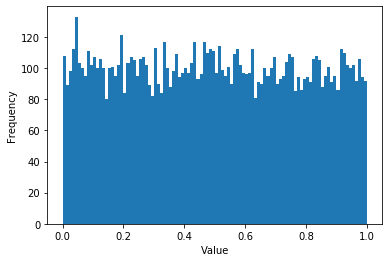

In [2]:
# create 100000 random numbers and plot them in a histogram of 100 bins. we should see pretty much
# equal bin size of 100 bins with 100 entries each
rn = np.random.rand(10000)

# make the histogram
plt.figure(1)
rn_hist = plt.hist(rn, bins=100)   # we are also going to save the histogram for further use...
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

You can print and run this histogram over and over again and will see that numbers are pretty equally distributed. Give it a try and plug in more random numbers. How high do you need to go, i.e., how many random numbers do you need to generate until the histogram looks pretty much flat?

Let us now have a look on what the mean and the standard deviation of this random number package looks like. Note: here we are checking how many entries the bins have on average (and not what the mean of the distribution is). We can use the associated numpy functions:

In [3]:
rn_avg = np.mean(rn_hist[0])
rn_std = np.std(rn_hist[0])
print("Average: %.3f, Standard deviation: %.3f" % (rn_avg, rn_std))

Average: 100.000, Standard deviation: 9.432


This looks pretty good, the average is where we expect it and the standard deviation makes sense too. We can also look at the mean of the distribution and its standard deviation:

In [4]:
print('Average: %.3f, Standard deviation: %.3f' %(np.mean(rn), np.std(rn)))

Average: 0.495, Standard deviation: 0.289


This looks as expected as well. So the random number generator seems to work. 

### Gaussian distributed random numbers
For a given measurement we usually don't assume that the uncerainty is distributed with equal chances. We expect a Gaussian distribution. NumPy has a function for this as well. Let us create 10000 samples that are Gaussian distributed around 0:

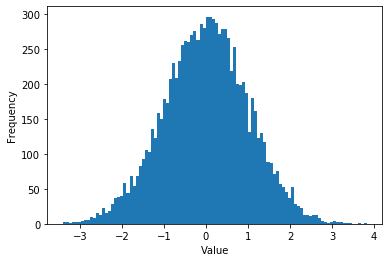

In [5]:
gn = np.random.randn(10000)   # Note: randn instead of rand - stands for 'random normal'

# plot a histogram
plt.figure(2)
gn_hist = plt.hist(gn, bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

This looks pretty Gaussian at first glance, so it seems to work. Let's have a look at the mean and standard deviation of all the values this time:

In [6]:
gn_avg = np.mean(gn)
gn_std = np.std(gn)
print('Average of distribution: %.3f, Standard deviation: %.3f' % (gn_avg, gn_std))

Average of distribution: 0.001, Standard deviation: 1.004


As expected, the average of the distribution is about zero. The standard deviation - big surprise - is about 1. This is expected, since this distribution is exactly used to define the standard deviation.

So far so good, our random number generators seem to work. Now let's define an experimental setup that we want to analyze. Let's choose a simple system that we can easily solve numerically as well.

## Experiment setup and analytical evaluation
Let us assume a radioactively decaying species. We measure the number of atoms at the beginning $N_0$ at the number of atoms after a given time t as $N(t)$. The radioactive decay equation with decay constant $\lambda$ can then be written as:

$$N(t) = N_0 \exp{(-\lambda t)}$$

Assuming we want to measure the decay constant $\lambda$, we can solve above equation for $\lambda$:

$$\lambda = \frac{1}{t} \ln \left(\frac{N(t)}{N_0}\right)$$
Of course, every measurement has an uncertainty. Let us define the uncertainty in the time measurement $t$ as $\sigma_t$, the uncertainty in $N(t)$ as $\sigma_N$ and the uncertainty in $N_0$ as $\sigma_0$. The derivatives of $\lambda$ for all the variablies with uncertainties are then:

$$\frac{\partial \lambda}{\partial t} = \frac{1 - \ln \left(\frac{N(t)}{N_0}\right)}{t^{2}}$$
$$\frac{\partial \lambda}{\partial N(t)} = \frac{1}{tN(t)}$$
$$\frac{\partial \lambda}{\partial N_0} = -\frac{1}{tN_0}$$

The propagated uncertainty of $\lambda$ can then be written as:

$$ \sigma_{\lambda} =  \left\{ \left[ \frac{1 - \ln \left(\frac{N(t)}{N_0}\right)}{t^{2}} \sigma_t \right]^2 + \left[ \frac{1}{tN(t)} \sigma_N \right]^2 + \left[ -\frac{1}{tN_0} \sigma_0 \right]^2 \right\}^{\frac{1}{2}}  $$

Let us set up some random measurement variables and calculate the decay constant and its uncertainty from it:

In [7]:
# Measurements:
nt = 50.
n0 = 100.
tmsr = 180.
sigma_nt = 5.
sigma_n0 = 10.
sigma_t = 1.

# Calculate lambda:
lam = 1. / tmsr * np.log(nt / n0)
print('Decay constant: lambda = %.5f' % lam)

# Calculate uncertainty:
sigma_lam = (((1 - np.log(nt/n0)) * sigma_t / tmsr**2.)**2. + (sigma_nt / (tmsr * nt))**2. + 
             (-sigma_n0 / (tmsr*n0))**2.)**0.5
print('Uncertainty of lambda: sigma_lambda = %.5f' % sigma_lam)
print('Uncertainty of lambda in %%: sigma_lambda = %.1f%%' % np.abs(sigma_lam / lam * 100.))

Decay constant: lambda = -0.00385
Uncertainty of lambda: sigma_lambda = 0.00079
Uncertainty of lambda in %: sigma_lambda = 20.4%


Sure, after all the derivations, this can be calculated, however, the chances of making a mistake can be rather high. We can evaluate the same uncertainty on $\lambda$ using MC error propagation. 

### MC uncertainty propoagation of the setup

Let us first define how many samples we want to consider for the MC setup:

In [8]:
# samples for MC setup
nint = 10000

Now we can calculate the value of $\lambda$ as many times as we have samples. Each time, the measurement uncertainties for $N(t)$, $N_0$, and $t$ can be varied randomly by adding the the standard deviation times a random number drawn from a gaussian distribution with standard deviation 1 to the respective value. 

Here we are using the same variables as before.

In [9]:
# calculate lambda samples -> this is a np.array with nint entries!
lamsamp = 1. / (tmsr + np.random.randn(nint) * sigma_t) * np.log((nt + np.random.randn(nint) * sigma_nt) / 
                                                                 (n0 + np.random.randn(nint) * sigma_n0))

While this looks also very complicated, it is actually fairly straight forward. You should first notice, that the equation is the same as above, where we calculated lambda. The only thing in addition is the following code, e.g., for $t$:
    
    tmsr + np.random.randn(nint) * sigma_t

Here we simply take a randomly drawn number from a Gaussian distribution and multiply it with the uncertainty of $t$, e.g., $\sigma_t$. The value that we effectively plug into the equation for $t$ is on average exactly what we expect $t$ to be, a gaussian distributed envelope around the mean value $t$ with standard deviation $\sigma_t$. 

This process is now repeated for every measurement, e.g.:

    nt + np.random.randn(nint) * sigma_nt
    n0 + np.random.randn(nint) * sigma_n0
    
**Attention:** Do NOT predefine the random number and then use the same random number to multiply with all uncertainties. This will induce highly correlated uncertainties into your system, which is something that you don't want (of course, unless the randomness is correlated to each other).

*Note:* Of course you do not have to choose from a Gaussian distribution, in fact, you can plug in any distribution that you would like! This is one of the huge advantages of MC error propoagation.

Let us know evaluate and calculate the uncertainty for lambda, i.e., we want to calculate the average decay constant, and its associated uncertainty.

In [10]:
print('MC calculation of lambda and the associated uncertainty:')
lamavg = np.average(lamsamp)
lamstd = np.std(lamsamp)
print('Average decay constant: lambda = %.5f' % lamavg)
print('Uncertainty of lambda: sigma_lambda = %.5f' % lamstd)
print('Uncertainty of lambda in %%: sigma_lambda = %.1f%%' % np.abs(lamstd / lamavg * 100.))

MC calculation of lambda and the associated uncertainty:
Average decay constant: lambda = -0.00384
Uncertainty of lambda: sigma_lambda = 0.00080
Uncertainty of lambda in %: sigma_lambda = 20.8%


These values, as you can see, agree very well with the propagated uncertaintes that we calculated above.

### Convergence of the MC error propagation

An important part of MC error propagation is to look for convergence, i.e., how good is the calculation if we repeat it over and over again. In order to test this, we can run the above calculation multiple times and then look at the standard deviation of the average value and average uncertainty that we calculate. To do so, let us first put above calculation into a subroutine:

In [11]:
def mccalc():
    lamsamp = 1. / (tmsr + np.random.randn(nint) * sigma_t) * np.log((nt + np.random.randn(nint) * sigma_nt) / 
                                                                     (n0 + np.random.randn(nint) * sigma_n0))
    # calculate average and standard deviation
    avg = np.average(lamsamp)
    std = np.std(lamsamp)
    
    # return the average and the standard deviation
    return avg, std

Now we can set up a test vector and run the MC calculation, e.g., 1000 times. Then we can define how much variation the current number of samples (10000) produce.

In [12]:
nconv = 1000
# define the average vector and std vector
vecavg = np.zeros(nconv)
vecstd = np.zeros(nconv)

# now we can run the subroutine nconv times and add the average and standard deviation to the respective cell in 
# vecavg and vecstd
for it in range(nconv):
    avgtmp, stdtmp = mccalc()
    vecavg[it] = avgtmp
    vecstd[it] = stdtmp
    
# let us know calculate the standard deviation of these two vectors and print them out in percent deviation from the 
# actual mean that is calculated
vecavgstdpercent = np.abs(np.std(vecavg) / np.mean(vecavg)) * 100.
vecstdstdpercent = np.std(vecstd) / np.mean(vecstd) * 100.

# print the results
print('The average of lambda calculated by MC is +/- : %.1f%%' %vecavgstdpercent)
print('The standard deviation of lambda calculated by MC is +/- : %.1f%%' %vecstdstdpercent)

The average of lambda calculated by MC is +/- : 0.2%
The standard deviation of lambda calculated by MC is +/- : 0.7%


These deviations are much smaller than the error itself, and thus perfectly justfied. 

*Note:* Every MC error propagation should contain a convergence test, i.e., you will need to test how well the MC error propagation works and if you have chosen enough samples.

## Exercises

 1. Write a python subroutine to go through above MC error propagation, however, this time give `nint` as a variable to the subroutine. Go through the same calculation as above and print out the uncertainties when choosing `nint` values of 10, 100, 100000.
 
 2. Use your routine from exercise 1 and create of the standard deviations of the MC error propagation error for the average and the standard deviation versus the number of samples `nint` chosen. Plot this figure such that the x axis is logarithmic, while the y axis is linear.  
 *Hint:* The following routines might be useful for your evaluation:  
 `plt.semilogx(...)`   
 Makes the plot such that the x axis is logarithmic while the y axis is linear  
 `np.logspace(startexp, stopexp, numb)`   
 Creates a logarithmically spaced array that starts at '10**(startexp)', ends at '10**(stopexp)' and contains 'numb' entries
 
 3. So far, you have tried to constrain convergence with `nconv` samples, maybe you have chosen 1000 samples as I did above. Decrease and increase this number and discuss your findings. Was `nconv = 1000` a good estimate? Why?  
 *Hint:* Look at the figure in exercise 2. From this figure you can see when nint is converged. It might be a good idea to use this nint to study the convergence of nconv.